In [10]:
from matplotlib import pyplot as plt
import os
import numpy as np
import torch
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")


In [11]:
# load all mnist data


np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)

# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)



# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train a flow of $D_p,D_q$

In [72]:
# Import required packages for RQNSF
import torch
import numpy as np
import normflows as nf
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt



from tqdm import tqdm

# on 2D Gaussian copula

In [107]:
# Set up RQNSF model

# Define flows
K = 1 # layers
torch.manual_seed(0)

latent_size = 2
hidden_units = 50
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribuiton
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

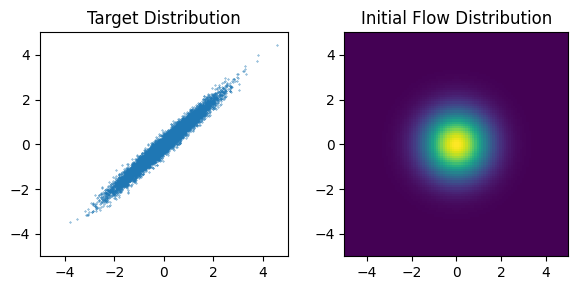

In [108]:
data_p = torch.distributions.MultivariateNormal(torch.zeros(2), torch.tensor([[1., 0.98], [0.98, 1.]])).sample((10000,)).to(device)

# Plot target distribution
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot target distribution
axes[0].scatter(data_p[:, 0].cpu().numpy(), data_p[:, 1].cpu().numpy(), s=0.1)
axes[0].set_title('Target Distribution')
axes[0].set_ylim(-5, 5)
axes[0].set_xlim(-5, 5)

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)
nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0
axes[1].pcolormesh(xx, yy, prob.data.numpy())
axes[1].set_ylim(-5, 5)
axes[1].set_xlim(-5, 5)
axes[1].set_aspect('equal', 'box')
axes[1].set_title('Initial Flow Distribution')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

C:\Users\u1819911\AppData\Local\Temp\ipykernel_3996\85605351.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data_p_and_q).float().to(device)
 50%|████▉     | 248/500 [00:15<00:13, 18.05it/s]

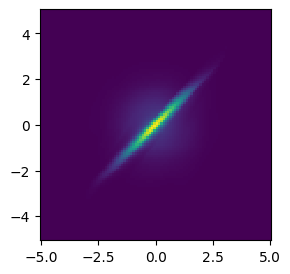

100%|█████████▉| 498/500 [00:29<00:00, 18.05it/s]

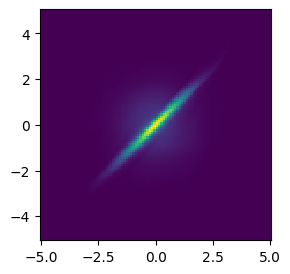

100%|██████████| 500/500 [00:29<00:00, 17.13it/s]


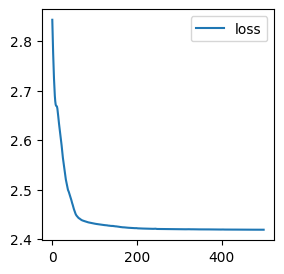

In [109]:
# Train model
max_iter = 500
show_iter = 250

data_p_and_q = torch.cat([data_p, torch.randn(data_p.shape)], 0)
data_p_and_q = data_p_and_q[torch.randperm(data_p_and_q.shape[0])]

x = torch.tensor(data_p_and_q).float().to(device)

loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad() 
    
    # Compute loss
    loss = nfm.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        nfm.eval()
        log_prob = nfm.log_prob(zz)
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(3, 3))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(3, 3))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

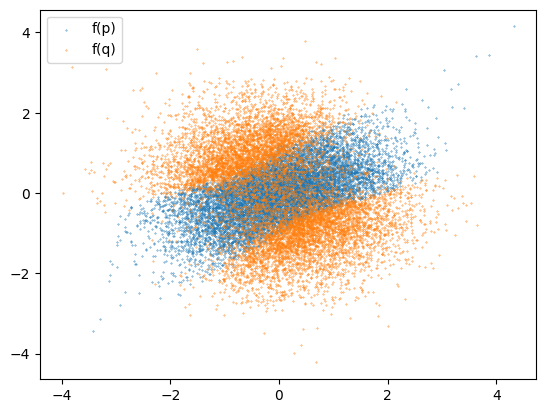

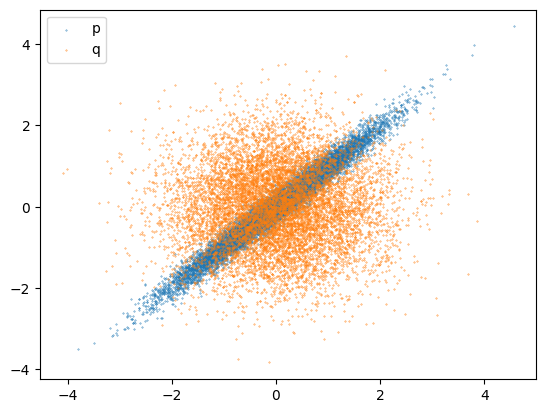

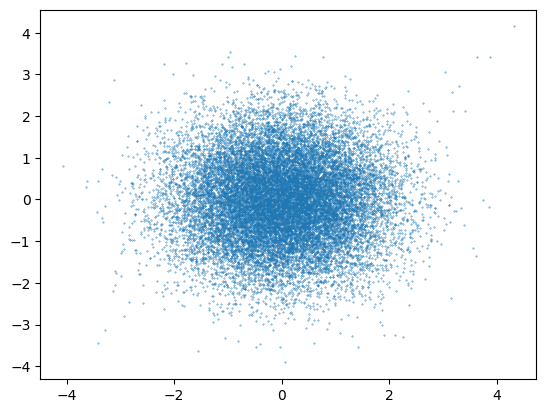

In [110]:
f_data_p = nfm.inverse(data_p)
f_data_q = nfm.inverse(torch.randn(data_p.shape))
plt.scatter(f_data_p[:, 0].detach().numpy(), f_data_p[:, 1].detach().numpy(), s=0.1, label='f(p)')
plt.scatter(f_data_q[:, 0].detach().numpy(), f_data_q[:, 1].detach().numpy(), s=0.1, label='f(q)')
plt.legend()
plt.show()

plt.scatter(data_p[:, 0].cpu().numpy(), data_p[:, 1].cpu().numpy(), s=0.1, label='p')
plt.scatter(torch.randn(data_p.shape)[:, 0].cpu().numpy(), torch.randn(data_p.shape)[:, 1].cpu().numpy(), s=0.1, label='q')
plt.legend()
plt.show()


f_data_p_and_q = nfm.inverse(data_p_and_q)
plt.scatter(f_data_p_and_q[:, 0].detach().numpy(), f_data_p_and_q[:, 1].detach().numpy(), s=0.1)

# on MNIST

In [ ]:
# load all mnist data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)

# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)



# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

In [163]:
# Set up RQNSF model

# Define flows
K = 1 # layers
torch.manual_seed(0)

latent_size = 28*28
hidden_units = 10
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribuiton
q0 = nf.distributions.DiagGaussian(28*28, trainable=False)
    
# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

In [ ]:
sample_rqnsf0 = nfm.sample(9)[0]
sample_rqnsf = torch.tensor(sample_rqnsf0, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
sample_rqnsf.shape

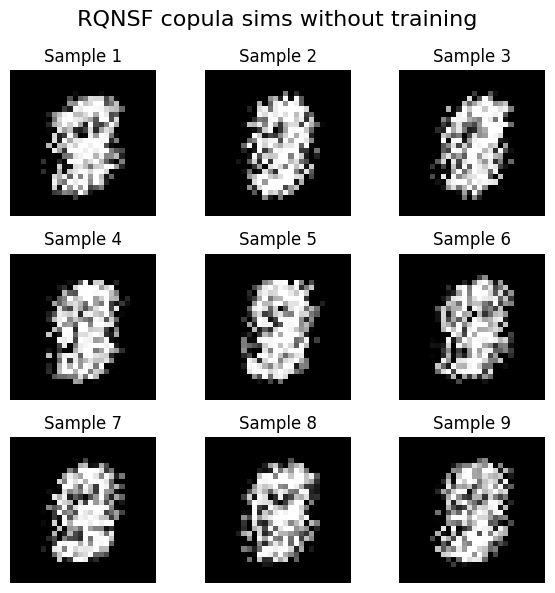

In [140]:
cop_sample_rqnsf = torch.torch.distributions.Normal(0, 1).cdf(sample_rqnsf).numpy()

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle(" RQNSF copula sims without training ", fontsize=16)

for i in range(3):
    for j in range(3):
        axes[i, j].imshow(reverse_transform(torch.tensor(cop_sample_rqnsf[i * 3 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 3 + j + 1}')

plt.tight_layout()
plt.show()

C:\Users\u1819911\AppData\Local\Temp\ipykernel_3996\781859367.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data_p_and_q).float().to(device)
100%|██████████| 500/500 [01:20<00:00,  6.22it/s]


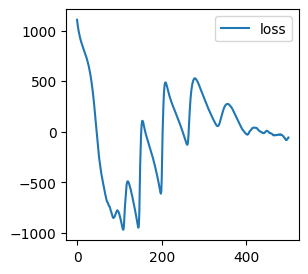

In [164]:
# Train model
max_iter = 500
show_iter = 250

data_p = X_train.reshape(-1, 28*28)
data_p_and_q = torch.cat([data_p[:100], torch.randn(data_p[:100].shape)], 0)
data_p_and_q = data_p_and_q[torch.randperm(data_p_and_q.shape[0])]

x = torch.tensor(data_p_and_q).float().to(device)

loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad() 
    
    # Compute loss
    loss = nfm.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
# Plot loss
plt.figure(figsize=(3, 3))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [165]:
sample_rqnsf_trained = nfm.sample(9)[0]
sample_rqnsf_trained = torch.tensor(sample_rqnsf_trained, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
sample_rqnsf_trained.shape

C:\Users\u1819911\AppData\Local\Temp\ipykernel_3996\3687410393.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_rqnsf_trained = torch.tensor(sample_rqnsf_trained, dtype=torch.float32).unsqueeze(1)  # Add channel dimension


torch.Size([9, 1, 784])

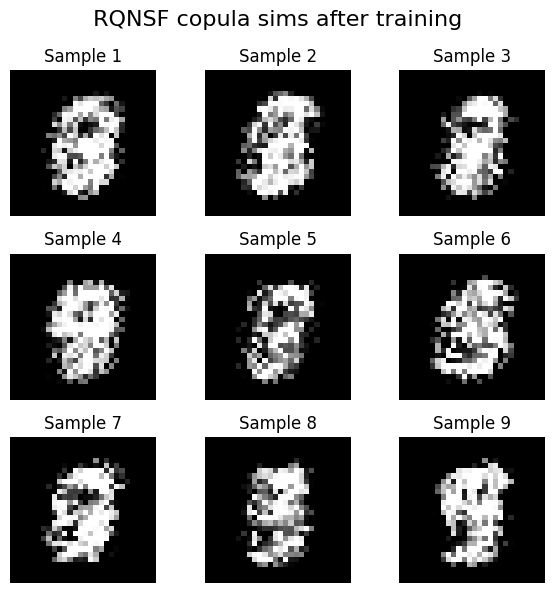

In [166]:
cop_sample_rqnsf = torch.torch.distributions.Normal(0, 1).cdf(sample_rqnsf_trained).numpy()

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle(" RQNSF copula sims after training ", fontsize=16)

for i in range(3):
    for j in range(3):
        axes[i, j].imshow(reverse_transform(torch.tensor(cop_sample_rqnsf[i * 3 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 3 + j + 1}')

plt.tight_layout()
plt.show()

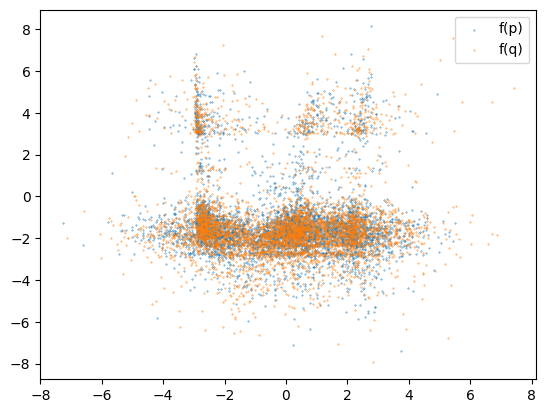

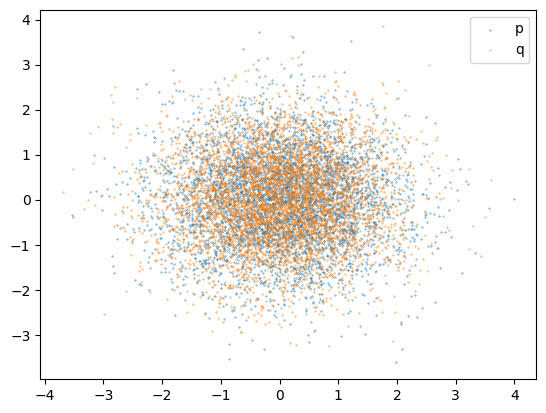

In [167]:
f_data_p = nfm.inverse(data_p[:5000])
f_data_q = nfm.inverse(torch.randn(data_p[:5000].shape))
plt.scatter(f_data_p[:, 500].detach().numpy(), f_data_p[:, 1].detach().numpy(), s=0.1, label='f(p)')
plt.scatter(f_data_q[:, 500].detach().numpy(), f_data_q[:, 1].detach().numpy(), s=0.1, label='f(q)')
plt.legend()
plt.show()

plt.scatter(data_p[:5000, 0].cpu().numpy(), data_p[:5000, 1].cpu().numpy(), s=0.1, label='p')
plt.scatter(torch.randn(data_p.shape)[:5000, 0].cpu().numpy(), torch.randn(data_p.shape)[:5000, 1].cpu().numpy(), s=0.1, label='q')
plt.legend()
plt.show()